# Genetic Algorithm for the La Corona Model (a COVID-themed El Farol Model)

This is an implementation of a COVID-themed El Farol Model where instead of the population trying to decide to go to the bar, they're deciding which grocery store to go to each week given how populated the one they went to was last few week. Some interesting differences between this model and the El Farol model is that every inidividual needs to go grocery shopping so it's possible, if the target capacity is low enough and the population great enough, that it's impossible to stay below the desired threshold for both grocery stores. Additionally, there are two centers in which the population can gain information. Therefore, individuals will not all have access to the same information each week. 

In [2]:
import numpy as np 
import random, operator, math
import pandas as pd 
import matplotlib.pyplot as plt

In [35]:

def rand_strat(mem, n_groc):
    return np.random.random(mem * n_groc)*2-1

class Person:

    def __init__(self, n_strat, mem, n_groc, elite_prop, mut_rate):

        self.mut_rate = mut_rate
        self.mem = mem
        self.elite_prop = elite_prop
        self.n_groc = n_groc
        self.strategies = []
        for i in range(n_strat):
            self.strategies.append(rand_strat(mem, n_groc))

        names = []
        for w in range(mem):
            for g in range(n_groc):
                names.append(chr(g+65) + str(w))
        
        self.strategies = pd.DataFrame(self.strategies)
        self.strategies.columns = names

        groc = list(range(0,n_groc))
        groc = [x+65 for x in groc]
        groc = list(map(chr, groc))
        
        groc = pd.DataFrame(columns = groc)

        for g in groc:
            self.strategies[g] = 0

        self.strategies["fitness"] = 0

        hist_g = []
        hist_pop = []
        for i in range(2 * mem):
            hist_g.append(chr(random.randint(0,n_groc-1)+65))
            hist_pop.append(random.random()*2)


        self.history = pd.DataFrame({"grocery":hist_g, "fullness":hist_pop})

        self.update_scores()

    
    def update_scores(self):

        self.strategies[self.strategies.columns[-self.n_groc:]] = 0

        for sindex, srow in self.strategies.iterrows():
            ctr = 0
            fitness = 0
            for hindex, hrow in self.history.iterrows():
                if ctr == self.mem: break
                ctr += 1
                
                srow[hrow.grocery] += srow[hrow.grocery + str(hindex)] * hrow.fullness
                
                stores = {}
                for i in range(self.n_groc):
                    stores[chr(i+65)] = 0

                for i in range(self.mem):
                    index = hindex + i
                    stores[self.history.iloc[index,0]] += srow[self.history.iloc[index,0] + str(index-hindex)] *                                                                 hrow.fullness
                top = max(stores, key=stores.get)
                if top == hrow.grocery and hrow.fullness <= 1: fitness += 1+hrow.fullness
                elif top == hrow.grocery and hrow.fullness > 1: fitness -= hrow.fullness
                elif top != hrow.grocery and hrow.fullness <= 1: fitness -= (1+hrow.fullness) / self.n_groc
                elif top != hrow.grocery and hrow.fullness > 1: fitness += hrow.fullness / self.n_groc

            srow.fitness = fitness
            self.strategies.loc[sindex] = srow

    def update_history(self,store,fullness):
        self.history.loc[-1] = {'grocery': store, 'fullness': fullness}  # adding a row
        self.history.index = self.history.index + 1  # shifting index
        self.history.sort_index(inplace=True) 
        self.history.drop(self.history.tail(1).index,inplace=True)

    def best_strategy(self):
        return self.strategies["fitness"].idxmax()

    def choice(self):
        return (self.strategies.iloc[self.best_strategy(),-(self.n_groc+1):-1].idxmax(axis=1))

    def elite(self):
        n = round(self.elite_prop * len(self.strategies))
        return self.strategies.sort_values(by = ["fitness"], ascending = False).head(n)
                
    def update_strategies(self):
        elite = self.elite()
        new_strats = elite
        
        for i in range(len(elite),len(self.strategies)-1):
            p1 = random.randint(0,len(elite)-1)
            p2 = random.randint(0,len(elite)-1)
            split = random.randint(0,len(elite.iloc[p1])-self.n_groc-2)
            child = elite.iloc[p1][0:split].append(elite.iloc[p2][split:len(elite.iloc[p2])])
            new_strats = new_strats.append(child, ignore_index = True)
          
        if random.random() < self.mut_rate:
            mut = random.randint(0,len(new_strats)-1)
            new_strats.iloc[mut] =  np.concatenate((rand_strat(self.mem, self.n_groc), 
                                                    np.array([0.]*(self.n_groc+1))))

        avg = elite.mean()
        new_strats = new_strats.append(avg, ignore_index = True)

        self.strategies = new_strats


In [36]:
class Model:

    def __init__(self, popsize, n_strat, mem, elite_prop, mut_rate, n_groc, capacity):

        self.stores = {}
        self.population = []
        self.week = 0

        for i in range(n_groc):
            self.stores[chr(i+65)] = [random.randint(1,capacity*2),capacity]

        for i in range(popsize):
            self.population.append(Person(n_strat,mem,n_groc,elite_prop,mut_rate))

    def choices(self):
        
        choices = []
        for i in range(len(self.population)):
            exp = self.stores[self.population[i].history.iloc[0,0]] 
            choices.append(self.population[i].choice())
        return choices
    
    def update_fullness(self):

        choices = self.choices()
        for store in self.stores:
            self.stores[store][0] = choices.count(store)
        
        return choices

    def next_week(self):

        choices = self.update_fullness()
        for i in range(len(self.population)):
            store = choices[i]
            self.population[i].update_history(store = choices[i],
                                              fullness = self.stores[store][0] / self.stores[store][1])
            self.population[i].update_strategies()
            self.population[i].update_scores()
        
        return self.stores

    def avg_strategies(self):
        avg = self.population[0].strategies
        for i in range(1,len(self.population)):
            avg += self.population[i].strategies
        return avg / len(self.population)


    def run_model(self, n_weeks, avg_strats = False, one_hist = False, 
                  one_strat = False, stores = False, plot = False):
        
        lines = []
        for i in range(len(self.stores)):
            lines.append([])

        if avg_strats: display(self.avg_strategies())
        for i in range(n_weeks):
            if one_strat: display(self.population[0].strategies)
            if stores: display(self.stores)
            if one_hist: display(self.population[0].history)
            m.next_week()
            
            for c in range(len(self.stores)):
                lines[c].append(self.stores[chr(c+65)][0])

        if avg_strats: display(self.avg_strategies())

        colors = ['green','blue','orange','red','purple','yellow','brown','violet','gray','black']

        if plot:
            for l in range(len(lines)):
                plt.plot(lines[l], label = chr(l+65), color = colors[l])
                plt.axhline(y=self.stores[chr(l+65)][1], xmin=0, xmax=1, color = colors[l])
                plt.xlabel("Weeks")
                plt.ylabel("Number of People")
                plt.legend()
            plt.show()


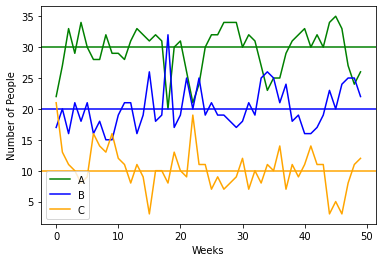

In [40]:
m = Model(popsize = 60,
          n_strat = 10,
          mem = 20,
          elite_prop = .5,
          mut_rate = .5,
          n_groc = 3,
          capacity = 50)

m.stores = {"A":[5 ,30],"B":[40,20],"C":[10,10]}

m.run_model(n_weeks = 50,
            avg_strats = False,
            one_hist = False,
            one_strat = False,
            stores = False,
            plot = True)